In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_excel("Sample - Superstore (1).xls")

# Data Exploration

In [2]:
#explore your dataframe and check the content
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
#explore your column names
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [4]:
#check the number of rows and columns with df.shape
df.shape

(9994, 21)

In [5]:
#we are going to forecast the furniture sales,
#build your new dataframe only based on furniture category and drop the rest of categories
df = df.loc[df['Category']=='Furniture']

In [6]:
#Check the first few rows of your dataframe
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [7]:
#check the shape of your new dataframe
df.shape

(2121, 21)

In [8]:
#check the min and max date you have in your dataframe
df['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [9]:
df['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

In [10]:
#Great Job, As you can see we have a good 4-year furniture sales data

# Data Preprocessing

In [11]:
#Remove unneeded columns
furniture_columns= ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit']
df.drop(furniture_columns,axis=1, inplace=True)

In [12]:
df.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


In [13]:
#sort your new dataframe in ascending order based on time
df.sort_values('Order Date')

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940
...,...,...
7636,2017-12-29,258.750
7632,2017-12-29,1207.840
5131,2017-12-29,101.120
7635,2017-12-29,300.980


In [14]:
#Check the rows for any missing data
df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [15]:
#group by your sales based on the order date and reset the index
df = df.groupby('Order Date')['Sales'].sum().reset_index()

In [16]:
df.columns

Index(['Order Date', 'Sales'], dtype='object')

In [17]:
#set the order date as your index column
df = df.set_index(['Order Date'])

In [18]:
df.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [19]:
#resample your data to 'MS' and use mean function
y = df['Sales'].resample('MS').mean()

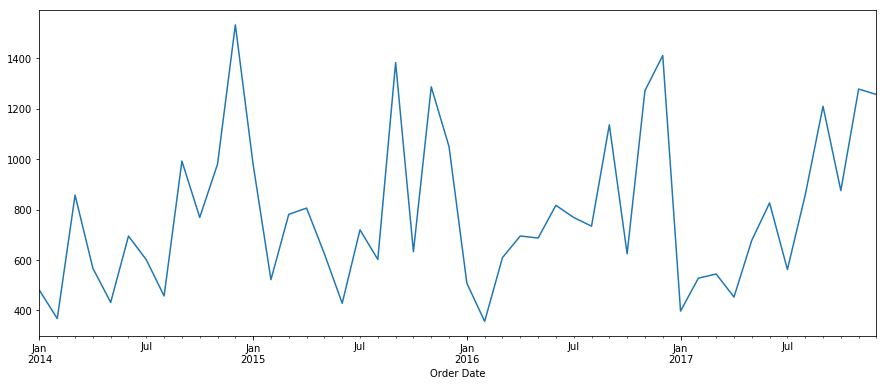

In [20]:
#use the line plot to see the entire database
import matplotlib.pyplot as plt
y.plot(figsize=(15, 6))
plt.show()

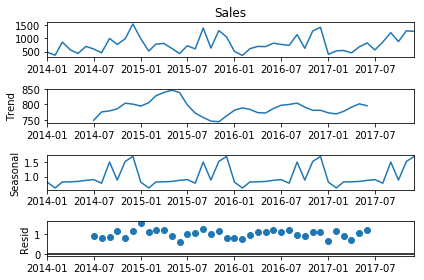

In [21]:
#import seasonal-decompose from the statsmodel and decompose the time series components in diffrent graphs

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y, model='mul')  # model='mul' also works
result.plot();

# Visualizing Furniture Sales Time Series Data

# Model selection and prediction

In [22]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima                              # for determining ARIMA orders

In [23]:
from pmdarima import auto_arima

In [24]:
import numpy as np
import pmdarima as pm

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
#As can be see there are seasonaly in our dataset, select the appropariate model 
#and train the model after finding the (p,d,q)(P,D,Q,M)

stepwise_fit = auto_arima(y,seasonal = True, m=12)

In [27]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -239.267
Date:                              Tue, 08 Sep 2020   AIC                            494.535
Time:                                      14:53:59   BIC                            507.203
Sample:                                           0   HQIC                           498.956
                                               - 48                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1943      1.681     -0.116      0.908      -3.489       3.101
ar.L1          1.7060      0.206      8.292      0.000       1.303       2.109
ar.L2         -0.8537      0.181     -4.723      0.000      -1.208      -0.499
ma.L1         -1.9400      2.000     -0.970      0.332      -5.859       1.979
ma.L2          0.9507      1.868      0.509      0.611      -2.711       4.613
ar.S.L12      -0.1218      0.563     -0.216      0.829      -1.225       0.982
ma.S.L12      -0.8579      3.168     -0.271      0.787      -7.068       5.352
sigma2      1.908e+04   7.07e+04      0.270      0.787   -1.19e+05    1.58e+05
===================================================================================
Ljung-Box (Q):                       41.01   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.22   Prob(JB):                         0.80
Heteroskedasticity (H):               0.45   Skew:                             0.04
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Split the data into train/test and fit the SARIMA

In [28]:
len(y)

48

In [29]:
train=y.iloc[:36]
test=y.iloc[36:]

In [49]:
#6. Obtain predicted values
model = SARIMAX(train,order=(2,1,2),seasonal_order=(2,1,2,12))
results = model.fit()
#results.summary()
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Predictions')

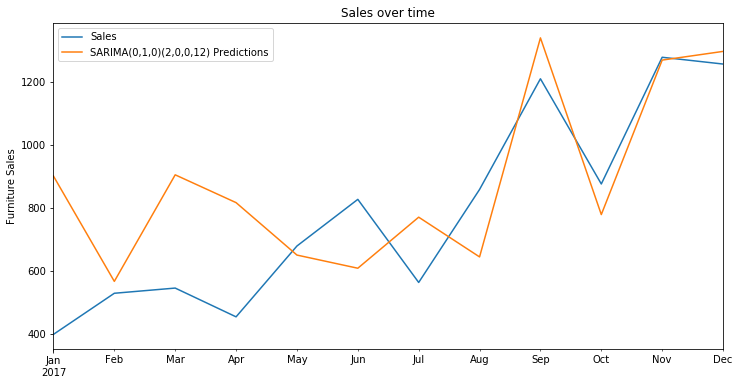

In [50]:
# Plot predictions against known values
title = 'Sales over time'
ylabel='Furniture Sales'
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Evaluate the Model

In [51]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 238.2075984


# visualize the entire period

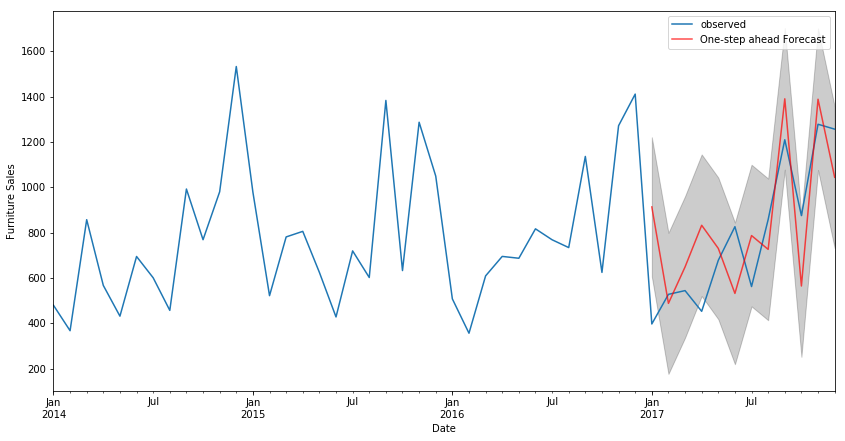

In [33]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(color = 'r', ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# Retrain the model

In [54]:
model = SARIMAX(y,order=(2,0,2),seasonal_order=(2,1,2,12))
results = model.fit()
fcast = results.predict(len(y),len(y)+36,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

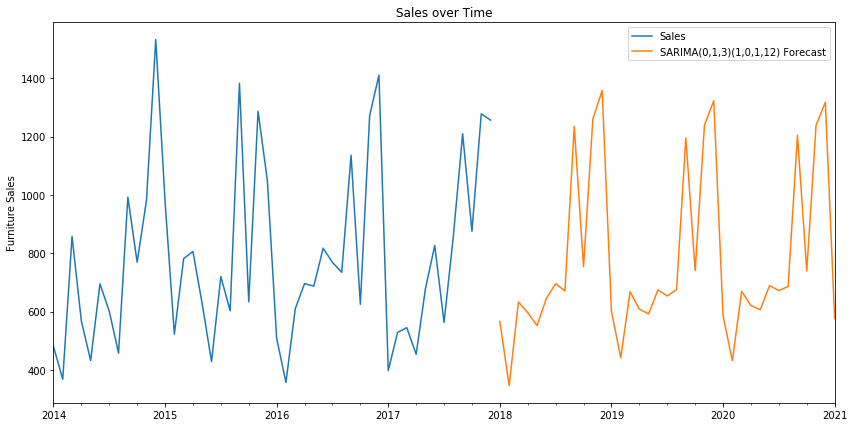

In [55]:
# Plot predictions against known values
title = 'Sales over Time'
ylabel='Furniture Sales'
xlabel=''

ax = y.plot(legend=True,figsize=(14,7),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

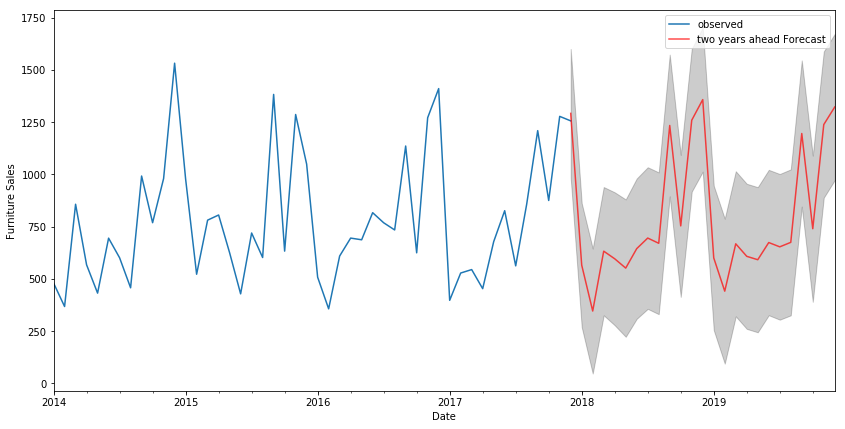

In [56]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-01'), end=pd.to_datetime('2019-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(color = 'r', ax=ax, label='two years ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()